<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/05-modern-training-techniques/04_hyperparameter_optimization_with_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Hyperparameter optimization with Optuna

The improvements so far have focused on optimizing when we have gradients.
But hyperparameters are things we would like to optimize for which we do not have
any gradients, such as the initial learning rate $\eta$ to use and the value of the momentum
term $\mu$. 

We would also like to optimize the architecture of our networks: 

should we use two layers or three? 

How about the number of neurons in each hidden layer?

The first hyperparameter tuning method most people learn in machine learning
is called grid search. 

While valuable, grid search works well only for optimizing one or two variables at a time due to its exponential cost as more variables are added.

When training a neural network, we usually have at least three parameters we want to optimize(number of layers, number of neurons in each layer, and learning rate $\eta$). 

We instead use a newer approach—**Optuna**—to tuning hyperparameters, which works much better.

Optuna does a better job of hyperparameter optimization by
using a Bayesian technique to model the hyperparameter problem as its own machine learning task.

For Optuna, we define a function that we want to minimize (or
maximize), which takes as input a trial object. This trial object is used to get guesses
for each parameter we want to tune and returns a score at the end.

<img src='images/6.png?raw=1' width='600'/>

Let’s look at a toy function that we want to minimize:

$$ 
f(x, y) = abs(x-3)*(y+2)
$$

It’s easy to tell that one minimum exists at $x = 3$ and $y = -2$.

So now, let's try to find it with Optuna.

##Setup

In [ ]:
!pip install optuna

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

from sklearn.datasets import make_moons

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import optuna

from idlmam import train_simple_network, Flatten, weight_reset, set_seed, run_epoch

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(45)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

We use the
Fashion-MNIST dataset because it is slightly more challenging while retaining the same
size and shape as the original MNIST corpus, which will let us accomplish some testing
in a reasonable time.

In [ ]:
epochs = 50
B = 256

train_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./data", train=False, transform=transforms.ToTensor(), download=True)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data, batch_size=B)

##Training algorithem

Some problems take just a few epochs, others take hundreds to thousands, and
both of these factors change based on how much data you have. 

For these reasons, I don’t like requiring a learning rate schedule to always be used. I like to work without one first and then add one based on the problem at hand. 

However, we must always use some kind of optimizer. So if none is given, we  use a good default.

In [ ]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None, 
                  score_funcs=None, epochs=50, device="cpu", checkpoint_file=None, 
                  lr_schedule=None, optimizer=None, disable_tqdm=False):
  """
  Train simple neural networks
    
  Keyword arguments:
  model -- the PyTorch model / "Module" to train
  loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
  train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
  val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
  test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
  score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
  epochs -- the number of training epochs to perform
  device -- the compute lodation to perform training
  lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
  optimizer -- the method used to alter the gradients for learning
  """
  if score_funcs == None:
    score_funcs = {}

  tracking = ["epoch", "total time", "train loss"]

  if val_loader  is not None:
    tracking.append("val loss")

  if test_loader is not None:
    tracking.append("test loss")
  
  for eval_score in score_funcs:
    tracking.append("train " + eval_score)
    if val_loader is not None:
      tracking.append("val " + eval_score)
    if test_loader is not None:
      tracking.append("test " + eval_score)

  # How long have we spent in the training loop?
  total_train_time = 0
  results = {}
  # Initialize every item with an empty list
  for item in tracking:
    results[item] = []

  if optimizer == None:
    # AdamW optimizer is a good default optimizer
    optimizer = torch.optim.AdamW(model.parameters())

  # Place the model on the correct compute resource (CPU or GPU)
  model.to(device)

  # iterating through all the data (batches) multiple times (epochs)
  for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    # Put the model in training mode
    model = model.train()

    # train the model
    total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
    
    results["total time"].append(total_train_time)
    results["epoch"].append(epoch)

    if val_loader is not None:
      #  Put the model to "evaluation" mode, b/c we don't want to make any updates!
      model = model.eval()
      with torch.no_grad():
        run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")

    # In PyTorch, the convention is to update the learning rate after every epoch
    if lr_schedule is not None:
      if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
        lr_schedule.step(results["val loss"][-1])
      else:
        lr_schedule.step()

    if test_loader is not None:
      model = model.eval()
      with torch.no_grad():
        run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    # lets us save the model, the optimizer state, and other information, all in one object
    if checkpoint_file is not None:
      torch.save({
          "epoch": epoch,
          "model_state_dict": model.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "results": results
      }, checkpoint_file)

  # Finally, convert the results into a pandas DataFrame
  return pd.DataFrame.from_dict(results)

##Training model

We have everything we need to train our model.

In [ ]:
D = 28 * 28       # input size
n = 128           # Hidden layer size
C= 1              # How many channels are in the input?
classes = 10      # How many classes are there?

In [ ]:
fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, classes)
)

Last, we need to settle on a default starting learning rate $\eta_0$. If we do not provide any kind of learning rate schedule $L(., .)$, then $\eta_0$ will be used for every epoch of training.

In [ ]:
eta_0 = 0.1 

Notice that we set the default learning rate $\eta_0$ in the optimizer’s
constructor. 

This is the standard process in PyTorch, and any LRSchedule object we
might use will reach into the optimizer object to alter the learning rate.

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=epochs, 
                          test_loader=testing_loader,
                          optimizer=torch.optim.SGD(fc_model.parameters(), lr=eta_0),
                          checkpoint_file="model.pt",
                          score_funcs={"Acc": accuracy_score},
                          device=device)

Let's quickly plot the training and validation
accuracy.

In [ ]:
fc_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,8.821117,1.008232,0.628697,0.642000,0.7756
1,1,14.509942,0.561391,0.618343,0.795767,0.7755
2,2,20.288430,0.493710,0.549053,0.821217,0.7904
3,3,25.969423,0.459425,0.497841,0.832617,0.8199
4,4,31.818383,0.436893,0.444015,0.842467,0.8384


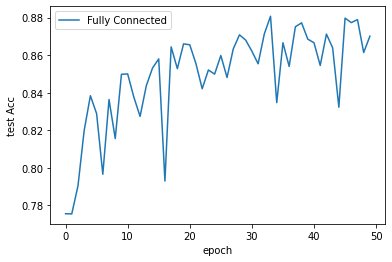

In [ ]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Fully Connected")

##Making better use of gradients